In [ ]:
from tensorflow.keras.utils import normalize
import os
import glob
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import albumentations as A
import albumentations.augmentations.functional as F
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as FF

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# #Resizing images, if needed
# SIZE_X = 256 
# SIZE_Y = 256
# n_classes=24  # number of classes for segmentation

# #Capture training image info as a list
# train_images = []
root = os.path.join('/content/drive/MyDrive/Data')
images_directory = os.path.join(root, 'image_dataset')
masks_directory = os.path.join(root, 'mask_dataset')


Size = 256
        

In [ ]:
# img_names = glob.glob('/content/drive/MyDrive/Data/image_dataset/*.jpg')
# msk_names = glob.glob('/content/drive/MyDrive/Data/mask_dataset/*.png')


In [ ]:
# img_names.sort()
# msk_names.sort()

In [ ]:
def preprocess_mask(mask):
    #mask = mask.astype(np.int32)
    #mask[mask != 3] = 0
    mask[ (mask == 0) | (mask == 1) | (mask == 3) | (mask == 4) | (mask == 5) | (mask == 8) | (mask == 10)
     | (mask == 11) | (mask == 13) | (mask == 14) | (mask == 15) | (mask == 16) | (mask == 17) | (mask == 18) | (mask == 19) | (mask == 20)
      | (mask == 21) | (mask == 23) | (mask == 24)] = 0
    mask[mask == 2] = 1 # grass
    mask[mask == 9] = 2 # dog
    mask[mask == 6] = 3 # tree
    mask[mask == 7] = 4 # sky
    mask[ (mask == 12) | (mask == 22)] = 5 # concrete/walkway
    
    return mask

In [ ]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:266]
val_images_filenames = correct_images_filenames[266:-10]
test_images_filenames = images_filenames[-10:]


In [ ]:
# !pip install -U albumentations
!pip install --upgrade git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1ec2_spf
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1ec2_spf


In [ ]:
import albumentations as A
# from albumentations.pytorch import ToTensorV2

In [ ]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [ ]:
class BackgroundDataset(torch.utils.data.Dataset):

    
    def __init__(
            self, 
            images_filenames,
            images_directory,
            masks_directory,
            classes=None,
            transform = None
    ):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        self.classes = classes
        
    
    def __getitem__(self, idx):
        
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.resize(image, (256,256))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.COLOR_BGR2RGB,
        )
        mask = preprocess_mask(mask)
        mask = cv2.resize(mask, (256,256))
        image = image.astype('uint8')
        
        if(self.transform is not None):
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask) 
            
            # h,w = mask.shape[0], mask.shape[1]
            # mask = torch.empty(h, w, dtype = torch.long)
            #mask = mask.long()  
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.permute(2, 0, 1)
            
            # h, w = mask.shape[1], mask.shape[2]
            # mask = torch.empty(h, w, dtype=torch.long)
            #mask = mask.float()/255
            
            
        else: 
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            
            # h,w = mask.shape[0], mask.shape[1]
            # mask = torch.empty(h, w, dtype = torch.long)
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.permute(2, 0, 1)
            
            # h, w = mask.shape[1], mask.shape[2]
            # mask = torch.empty(h, w, dtype=torch.long)
            #mask = mask.float()/255
            
          
        return image, mask  
        
    def __len__(self):
        return len(self.images_filenames)

In [ ]:
test_transform = A.Compose(
    [A.PadIfNeeded(min_height=256, min_width=256, border_mode=4), A.Resize(256, 256),]
)

train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256, border_mode=4),
        A.Resize(256, 256),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)

In [ ]:

CLASSES = ['background', 'grass', 'dog', 'tree', 'sky', 'concrete/walkway']
ACTIVATION = None
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

In [ ]:
train_dataset = BackgroundDataset(
    train_images_filenames, images_directory, masks_directory,
    classes=CLASSES, transform=train_transform
)

valid_dataset = BackgroundDataset(
    test_images_filenames, images_directory, masks_directory,
    classes=CLASSES, transform=test_transform
)


# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [ ]:

batch = next(iter(train_loader))
images, labels = batch
print(images.shape, labels.shape, type(images), type(labels), images.dtype, labels.dtype)

torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.uint8


In [ ]:

testImg = images[1]
testMsk = labels[1]
print(testImg.shape, testImg.dtype, type(testImg), testMsk.shape, 
testMsk.dtype, type(testMsk), testImg.min(), 
testImg.max(), testMsk.min(), testMsk.max())

torch.Size([3, 256, 256]) torch.float32 <class 'torch.Tensor'> torch.Size([3, 256, 256]) torch.uint8 <class 'torch.Tensor'> tensor(0.) tensor(1.) tensor(0, dtype=torch.uint8) tensor(192, dtype=torch.uint8)


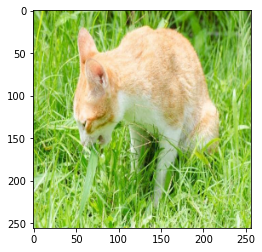

In [ ]:
plt.imshow(testImg.permute(1,2,0))
plt.show()

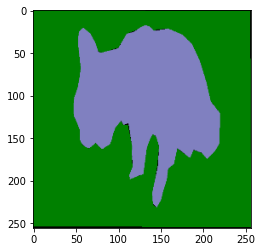

In [ ]:
plt.imshow(testMsk.permute(1,2,0))
plt.show()

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3, 
    classes=len(CLASSES), 
    activation=ACTIVATION
)

In [ ]:
#Define Loss and Metrics to Monitor (Make sure mode = "multiclass") ======================================
loss = smp.losses.DiceLoss(mode="multiclass")
loss.__name__ = 'Dice_loss'
#Will not monitor any metircs other than loss. 
#metrics=[]

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 60

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
# loss = smp.utils.losses.DiceLoss(mode="multiclass")

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

In [ ]:


if TRAINING:

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, '/content/drive/MyDrive/Data/Grass_5_labels2_best_model.pth')
            print('Model saved!')


Epoch: 0
train:   0%|          | 0/67 [00:12<?, ?it/s]


RuntimeError: ignored

In [ ]:
# import os
# import torch
# # load best saved model checkpoint from the current run
# if os.path.exists('/content/drive/MyDrive/Data/Grass_5_multi_best_model.pth'):
#     best_model = torch.load('/content/drive/MyDrive/Data/Grass_5_multi_best_model.pth', map_location=torch.device('cpu'))
#     print('Loaded UNet model from this run.')

# # load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input/unet-resnet50-for-scene-understanding-pytorch/best_model.pth'):
#     best_model = torch.load('../input/unet-resnet50-for-scene-understanding-pytorch/best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from a previous commit.')

In [ ]:
# class BackgroundDataset_Test(torch.utils.data.Dataset):

    
#     def __init__(
#             self, 
#             images_filenames = None,
#             images_directory = None,
#             masks_directory = None,
#             class_rgb_values=None, 
#             augmentation=None, 
#             preprocessing=None,
#     ):
#         self.images_filenames = images_filenames
#         self.images_directory = images_directory
#         self.masks_directory = masks_directory
        
        
#         self.class_rgb_values = class_rgb_values
#         self.augmentation = augmentation
#         self.preprocessing = preprocessing
    
#     def __getitem__(self, idx):
        
#         image_filename = self.images_filenames[idx]
#         image = cv2.imread(os.path.join(self.images_directory, image_filename))
#         image = cv2.resize(image, (256,256))
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(
#             os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.COLOR_BGR2RGB,
#         )
#         mask = cv2.resize(mask, (256,256))
        
#         # one-hot-encode the mask
#         # mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
#         # apply augmentations
#         if self.augmentation:
#             sample = self.augmentation(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
        
#         # apply preprocessing
#         if self.preprocessing:
#             sample = self.preprocessing(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
            
#         return image, mask
        
#     def __len__(self):
#         return len(self.images_filenames)

In [ ]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BackgroundDataset(
    valid_images_filenames, images_directory, masks_directory,
    classes=CLASSES, transform=test_transform
)

test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

In [ ]:
logs = val_epoch.run(test_loader)

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

for i in range(10):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset[n][0].permute(1,2,0)
    image_vis = image_vis.numpy()*255
    image_vis = image_vis.astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    m = nn.Softmax(dim=1)
    pr_probs = m(pr_mask)              
    pr_mask = torch.argmax(pr_probs, dim=1).squeeze(1)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [ ]:
sample_preds_folder = '/content/drive/MyDrive/Data/sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    # pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # from CHW format to HWC format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values), true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        
    )

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model = model,
    # model = best_model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

In [ ]:
import pandas as pd

train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()